In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.metrics import SCORERS, r2_score
from scipy import sparse
from datetime import datetime, date, timedelta
import calendar
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pickle

# I. Import des données

Quelques lignes posent problème à l'intégration, on les ignore

In [3]:
df = pd.read_csv("projet 3/2016_01.csv", sep=",", low_memory=False)
for i in range(2, 13):
    deleted_rows = []
    if i < 10:
        n = '0' + str(i)
    else:
        n = str(i)
    tmp = pd.read_csv("projet 3/2016_" + n + ".csv", sep=",", low_memory=False, error_bad_lines=False)
    
    if i == 4:
        tmp = tmp.drop(tmp.index[[88686, 385885, 455021, 454115, 461808]])

    df = df.append(tmp)

b'Skipping line 121012: expected 65 fields, saw 75\nSkipping line 386249: expected 65 fields, saw 83\nSkipping line 388291: expected 65 fields, saw 78\nSkipping line 389371: expected 65 fields, saw 72\nSkipping line 389548: expected 65 fields, saw 81\nSkipping line 453858: expected 65 fields, saw 97\n'


In [3]:
df.shape

(5635973, 65)

In [4]:
df.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'CARRIER', 'TAIL_NUM', 'FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE',
       'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY

In [4]:
df = df.drop(columns=['YEAR', 'FLIGHTS', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME',
       'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'Unnamed: 64'])

In [5]:
#the number of missing data is negligible compared to the size of the observations
df = df.dropna(subset=['ARR_DELAY'])
df = df.dropna(subset=['DEP_DELAY'])
df = df.reset_index(drop=True)

# II. Feature engineering

Nous avons des données temporelles, profitons en pour calculer l'évolution du retard moyen (avant le départ) sur l'aéroport à l'aller et à l'arrivée.

In [6]:
#first we put the departure date in the right format
f = lambda row: datetime(2016, int(row['MONTH']), int(row['DAY_OF_MONTH']), int(row['CRS_DEP_TIME'] / 100), int(row['CRS_DEP_TIME'] - 100*int(row['CRS_DEP_TIME'] / 100)),0)
df['departure_date'] = df.apply(f, axis=1)

/!\ Les prochaines étapes prennent beaucoup de temps de calcul.

## i. Evolution du retard au départ

In [7]:
#we reduce the dimensionality of df
df_reduced = pd.DataFrame()
df_reduced['AIRLINE_ID'] = df['AIRLINE_ID']
df_reduced['ORIGIN_AIRPORT_ID'] = df['ORIGIN_AIRPORT_ID']
df_reduced['DEP_DELAY'] = df['DEP_DELAY']
df_reduced['departure_date'] = df['departure_date']

df_reduced_grouped = df_reduced.sort_values(by=['departure_date']).groupby(['AIRLINE_ID', 'ORIGIN_AIRPORT_ID'])

In [8]:
df_rolled_1h = pd.DataFrame(columns = ['AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'DEP_DELAY', 'departure_date'])
df_rolled_2h = pd.DataFrame(columns = ['AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'DEP_DELAY', 'departure_date'])
df_rolled_3h = pd.DataFrame(columns = ['AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'DEP_DELAY', 'departure_date'])
for to_roll in df_reduced_grouped:
    df_rolled_1h = df_rolled_1h.append(to_roll[1].rolling(window='1h', on='departure_date', closed='right').mean().fillna(0.0))
    df_rolled_2h = df_rolled_2h.append(to_roll[1].rolling(window='2h', on='departure_date', closed='right').mean().fillna(0.0))
    df_rolled_3h = df_rolled_3h.append(to_roll[1].rolling(window='3h', on='departure_date', closed='right').mean().fillna(0.0))

In [9]:
df_rolled_1h.columns = ['AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'MEAN_1H_DEP_DELAY', 'departure_date']
df_rolled_2h.columns = ['AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'MEAN_2H_DEP_DELAY', 'departure_date']
df_rolled_3h.columns = ['AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'MEAN_3H_DEP_DELAY', 'departure_date']
df_featured = df.join(df_rolled_1h.loc[:,['MEAN_1H_DEP_DELAY']], how='inner')
df_featured = df_featured.join(df_rolled_2h.loc[:,['MEAN_2H_DEP_DELAY']], how='inner')
df_featured = df_featured.join(df_rolled_3h.loc[:,['MEAN_3H_DEP_DELAY']], how='inner')

## ii. Evolution du retard à l'arrivée

In [10]:
#we reduce the dimensionality of df
df_reduced = pd.DataFrame()
df_reduced['AIRLINE_ID'] = df['AIRLINE_ID']
df_reduced['DEST_AIRPORT_ID'] = df['DEST_AIRPORT_ID']
df_reduced['ARR_DELAY'] = df['ARR_DELAY']
df_reduced['departure_date'] = df['departure_date']

df_reduced_grouped = df_reduced.sort_values(by=['departure_date']).groupby(['AIRLINE_ID', 'DEST_AIRPORT_ID'])

In [11]:
df_rolled_1h = pd.DataFrame(columns = ['AIRLINE_ID', 'DEST_AIRPORT_ID', 'ARR_DELAY', 'departure_date'])
df_rolled_2h = pd.DataFrame(columns = ['AIRLINE_ID', 'DEST_AIRPORT_ID', 'ARR_DELAY', 'departure_date'])
df_rolled_3h = pd.DataFrame(columns = ['AIRLINE_ID', 'DEST_AIRPORT_ID', 'ARR_DELAY', 'departure_date'])
for to_roll in df_reduced_grouped:
    df_rolled_1h = df_rolled_1h.append(to_roll[1].rolling(window='1h', on='departure_date', closed='right').mean().fillna(0.0))
    df_rolled_2h = df_rolled_2h.append(to_roll[1].rolling(window='2h', on='departure_date', closed='right').mean().fillna(0.0))
    df_rolled_3h = df_rolled_3h.append(to_roll[1].rolling(window='3h', on='departure_date', closed='right').mean().fillna(0.0))

In [12]:
df_rolled_1h.columns = ['AIRLINE_ID', 'DEST_AIRPORT_ID', 'MEAN_1H_ARR_DELAY', 'departure_date']
df_rolled_2h.columns = ['AIRLINE_ID', 'DEST_AIRPORT_ID', 'MEAN_2H_ARR_DELAY', 'departure_date']
df_rolled_3h.columns = ['AIRLINE_ID', 'DEST_AIRPORT_ID', 'MEAN_3H_ARR_DELAY', 'departure_date']
df_featured = df_featured.join(df_rolled_1h.loc[:,['MEAN_1H_ARR_DELAY']], how='inner')
df_featured = df_featured.join(df_rolled_2h.loc[:,['MEAN_2H_ARR_DELAY']], how='inner')
df_featured = df_featured.join(df_rolled_3h.loc[:,['MEAN_3H_ARR_DELAY']], how='inner')

## iii. Jour fériés et week-end

Plutôt qu'utiliser l'information quel jour de la semaine et du mois nous sommes, nous allons rajouter un indicateur pour les jours fériés, les vacances nationales et les week-end, qui sont susceptibles d'être plus enclin à des retards. Nous conserverons l'information par mois car les saisons peuvent avoir un impact.

In [13]:
#for estimating the n-th weekday of a given (month, year)
def floating_date(year, month, weekday, n):
    dt = timedelta(days=1)
    tmp = date(year, month, 1)
    
    while tmp.weekday() != weekday:
        tmp += dt
        
    tmp += timedelta(weeks=n-1)
    
    return tmp

In [14]:
def is_public_holiday(dt):
    year = dt.year
    dt_tmp = date(dt.year, dt.month, dt.day)
    holidays = [date(year, 12, 25), #Christmas
                floating_date(year, 11, calendar.THURSDAY, 4), #Thanksgiving
                floating_date(year, 5, calendar.SUNDAY, 2), #Mother's day
                floating_date(year, 4, calendar.SUNDAY, 3), #Easter
                date(year, 7, 4), #Independance day
                floating_date(year, 6, calendar.SUNDAY, 3), #Father's day
                date(year, 5, 31), #Halloween
                date(year, 2, 14), #Valentine's day
                date(year, 3, 17), #Saint Patrick's day
                date(year, 12, 31), #New year's Eve
                date(year, 1, 1), #New year's Day
                floating_date(year, 1, calendar.MONDAY, 3), #Martin Luther King's day
                floating_date(year, 2, calendar.MONDAY, 3), #Washington's Birthday
                floating_date(year, 5, calendar.MONDAY, 4), #Memorial's day
                floating_date(year, 9, calendar.MONDAY, 1), #Labor day
                floating_date(year, 10, calendar.MONDAY, 2), #Columbus day
                date(year, 11, 11), #Veterans Day
                ]
    
    return dt_tmp in holidays

In [15]:
f = lambda row: 1 if is_public_holiday(row['departure_date']) else 0
df_featured['IS_PUBLIC_HOLIDAY'] = df_featured.apply(f, axis=1)

On exporte les données pour éviter le temps d'avoir à refaire les calculs la prochaine fois.

In [16]:
df_featured.to_csv('df_featured.csv', index=False)

# III. Régression

In [3]:
df = pd.read_csv('df_featured.csv', sep=',')

In [4]:
#prepare the inputs
encoder = LabelEncoder()
scaler = StandardScaler()
X1 = pd.DataFrame()
X1['AIRLINE_ID'] = encoder.fit_transform(df.loc[:,['AIRLINE_ID']].values.ravel())
X1['ORIGIN_AIRPORT_ID'] = encoder.fit_transform(df.loc[:,['ORIGIN_AIRPORT_ID']].astype(float).values.ravel())
X1['DEST_AIRPORT_ID'] = encoder.fit_transform(df.loc[:,['DEST_AIRPORT_ID']].astype(float).values.ravel())
X1['DAY_OF_WEEK'] = df['DAY_OF_WEEK']
#X1['IS_PUBLIC_HOLIDAY'] = df['IS_PUBLIC_HOLIDAY']
X1['MONTH'] = df['MONTH']
X1['DEP_TIME'] = df['DEP_TIME'].astype(float)
X1['MEAN_3H_DEP_DELAY'] = df['MEAN_3H_DEP_DELAY']
X1['MEAN_2H_DEP_DELAY'] = df['MEAN_2H_DEP_DELAY']
X1['MEAN_1H_DEP_DELAY'] = df['MEAN_1H_DEP_DELAY']

X2 = pd.DataFrame(X1.loc[:, ['AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 
                             'DEST_AIRPORT_ID', 
                             'MONTH', 'DEP_TIME']])
X2['DAY_OF_WEEK'] = df['DAY_OF_WEEK']
#X2['IS_PUBLIC_HOLIDAY'] = df['IS_PUBLIC_HOLIDAY']
X2['DEP_DELAY'] = df['DEP_DELAY']
X2['MEAN_3H_ARR_DELAY'] = df['MEAN_3H_ARR_DELAY']
X2['MEAN_2H_ARR_DELAY'] = df['MEAN_2H_ARR_DELAY']
X2['MEAN_1H_ARR_DELAY'] = df['MEAN_1H_ARR_DELAY']
X2['DISTANCE'] = scaler.fit_transform(df['DISTANCE'].values.reshape(-1, 1))

In [5]:
#prepare the outputs
Y1 = pd.DataFrame()
Y1['DEP_DELAY'] = df['DEP_DELAY']
Y2 = pd.DataFrame()
Y2['ARR_DELAY'] = df['ARR_DELAY']

A partir de maintenant on va évaluer différents algorithmes sur leur performance pour prédire le départ au décollage et le départ à l'arrivée.

In [6]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1.values, test_size=0.30)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2.values, test_size=0.30)

## i. Linear regression 

Prédiction du retard au décollage

In [25]:
lr = linear_model.LinearRegression()
lr.fit(X1_train,y1_train)
y_pred = lr.predict(X1_test)
print(mean_absolute_error(y1_test, y_pred))

10.124913236761959


Prédiction du retard à l'arrivée

In [26]:
lr.fit(X2_train,y2_train)
y_pred = lr.predict(X2_test)
print(mean_absolute_error(y2_test, y_pred))

8.3953787295013


## ii. Ridge regression

La régression ridge disposant d'un paramètre (alpha), on va utiliser la cross-validation pour déterminer le meilleur alpha possible.

In [43]:
#on departure delay
ridge = linear_model.Ridge()
n_alphas = 10
ridge_params = { 'alpha': np.logspace(-10, 10, n_alphas) }
ridge_CV = GridSearchCV(ridge, ridge_params, scoring = 'neg_mean_absolute_error', cv = 5)
ridge_CV.fit(X1_train, y1_train)
ridge = linear_model.Ridge(alpha=ridge_CV.best_params_['alpha'])
ridge.fit(X1_train, y1_train)
y_pred = ridge.predict(X1_test)
print(mean_absolute_error(y1_test, y_pred))

10.111614251622997


In [44]:
ridge_CV.best_params_

{'alpha': 359381.36638046405}

In [45]:
#on arrival delay
ridge = linear_model.Ridge()
n_alphas = 10
ridge_params = { 'alpha': np.logspace(-10, 10, n_alphas) }
ridge_CV_arr = GridSearchCV(ridge, ridge_params, scoring = 'neg_mean_absolute_error', cv = 5)
ridge_CV_arr.fit(X2_train, y2_train)
ridge = linear_model.Ridge(alpha=ridge_CV_arr.best_params_['alpha'])
ridge.fit(X2_train, y2_train)
y_pred = ridge.predict(X2_test)
print(mean_absolute_error(y2_test, y_pred))

8.377674881238404


In [46]:
ridge_CV_arr.best_params_

{'alpha': 2154.4346900318865}

/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


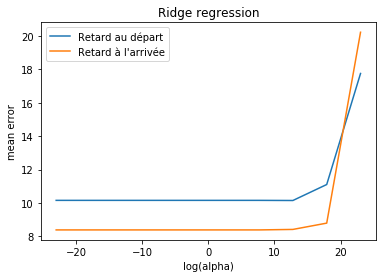

In [35]:
fix, ax = plt.subplots()
ax.plot(np.log([x['alpha'] for x in ridge_CV.cv_results_['params']]), -ridge_CV.cv_results_['mean_train_score'], label='Retard au départ')
ax.plot(np.log([x['alpha'] for x in ridge_CV_arr.cv_results_['params']]), -ridge_CV_arr.cv_results_['mean_train_score'], label='Retard à l\'arrivée')
plt.xlabel('log(alpha)')
plt.ylabel('mean error')
plt.title('Ridge regression')
ax.legend(loc='upper left')

## iii. Lasso regression

In [47]:
#on departure delay
lasso = linear_model.Lasso()
n_alphas = 10
lasso_params = { 'alpha': np.logspace(-10, 10, n_alphas) }
lasso_CV = GridSearchCV(lasso, lasso_params, scoring = 'neg_mean_absolute_error', cv = 5)
lasso_CV.fit(X1_train, y1_train)
lasso = linear_model.Lasso(alpha=lasso_CV.best_params_['alpha'])
lasso.fit(X1_train, y1_train)
y_pred = lasso.predict(X1_test)
print(mean_absolute_error(y1_test, y_pred))

/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10.110651052351583


In [48]:
lasso_CV.best_params_

{'alpha': 0.07742636826811278}

In [49]:
#on arrival delay
lasso = linear_model.Lasso()
n_alphas = 10
lasso_params = { 'alpha': np.logspace(-10, 10, n_alphas) }
lasso_CV_arr = GridSearchCV(lasso, lasso_params, scoring = 'neg_mean_absolute_error', cv = 5)
lasso_CV_arr.fit(X2_train, y2_train)
lasso = linear_model.Lasso(alpha=lasso_CV_arr.best_params_['alpha'])
lasso.fit(X2_train, y2_train)
y_pred = lasso.predict(X2_test)
print(mean_absolute_error(y2_test, y_pred))

/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


8.377340212007564


In [50]:
lasso_CV_arr.best_params_

{'alpha': 0.07742636826811278}

/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


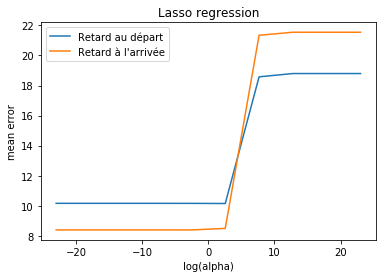

In [41]:
fix, ax = plt.subplots()
ax.plot(np.log([x['alpha'] for x in lasso_CV.cv_results_['params']]), -lasso_CV.cv_results_['mean_train_score'], label='Retard au départ')
ax.plot(np.log([x['alpha'] for x in lasso_CV_arr.cv_results_['params']]), -lasso_CV_arr.cv_results_['mean_train_score'], label='Retard à l\'arrivée')
plt.xlabel('log(alpha)')
plt.ylabel('mean error')
plt.title('Lasso regression')
ax.legend(loc='upper left')

## iv. ElasticNet regression

In [11]:
#on departure delay
elasticnet = linear_model.ElasticNet()
n_alphas = 10
elasticnet_params = { 'alpha': np.logspace(-10, 10, n_alphas) }
elasticnet_CV = GridSearchCV(elasticnet, elasticnet_params, scoring = 'neg_mean_absolute_error', cv = 5)
elasticnet_CV.fit(X1_train, y1_train)
elasticnet = linear_model.ElasticNet(alpha=elasticnet_CV.best_params_['alpha'])
elasticnet.fit(X1_train, y1_train)
y_pred = elasticnet.predict(X1_test)
print(mean_absolute_error(y1_test, y_pred))

/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10.110706669063905


In [12]:
elasticnet_CV.best_params_

{'alpha': 0.07742636826811278}

In [13]:
#on departure delay
elasticnet = linear_model.ElasticNet()
n_alphas = 10
elasticnet_params = { 'alpha': np.logspace(-10, 10, n_alphas) }
elasticnet_CV = GridSearchCV(elasticnet, elasticnet_params, scoring = 'neg_mean_absolute_error', cv = 5)
elasticnet_CV.fit(X2_train, y2_train)
elasticnet = linear_model.ElasticNet(alpha=elasticnet_CV.best_params_['alpha'])
elasticnet.fit(X2_train, y2_train)
y_pred = elasticnet.predict(X2_test)
print(mean_absolute_error(y2_test, y_pred))

/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/linear_model/coo

8.39361592834806


In [14]:
elasticnet_CV.best_params_

{'alpha': 0.0004641588833612782}

# IV. Random forest

In [7]:
gbm = lgb.LGBMRegressor(objective='regression')

#gbm_params = { 'learning_rate': np.linspace(5.0, 50.0, 5)/1000, 'num_leaves': np.linspace(30, 300, 5).astype(int), 'max_depth': np.linspace(10, 40, 4).astype(int) }
gbm_params = { 'learning_rate': np.linspace(5.0, 50.0, 5)/1000 }
#gbm_params = { 'num_leaves': np.linspace(30, 300, 5).astype(int) }
#gbm_params = { 'max_depth': np.linspace(10, 40, 4).astype(int) }
#gbm_params = { 'n_estimators': np.linspace(50, 500, 5).astype(int) }

gbm_CV = GridSearchCV(gbm, gbm_params, scoring = 'neg_mean_absolute_error', cv = 5)

gbm_CV.fit(X1_train, y1_train.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': array([0.005  , 0.01625, 0.0275 , 0.03875, 0.05   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [8]:
gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=100,
                        learning_rate=gbm_CV.best_params_['learning_rate'], 
                        max_depth=gbm_CV.best_params_['max_depth'], 
                        num_leaves=gbm_CV.best_params_['num_leaves'])
gbm.fit(X1_train, y1_train.ravel())
y_pred = gbm.predict(X1_test)
print(mean_absolute_error(y1_test, y_pred))

KeyError: 'max_depth'

In [ ]:
lgb.plot_importance(gbm)

In [48]:
gbm_CV.best_params_

{'learning_rate': 0.05, 'max_depth': 20, 'num_leaves': 300}

In [9]:
gbm = lgb.LGBMRegressor(objective='regression')

#gbm_params = { 'learning_rate': np.linspace(5.0, 50.0, 5)/1000, 'num_leaves': np.linspace(30, 300, 5).astype(int), 'max_depth': np.linspace(10, 40, 4).astype(int) }
gbm_params = { 'learning_rate': np.linspace(5.0, 50.0, 5)/1000 }
#gbm_params = { 'num_leaves': np.linspace(30, 300, 5).astype(int) }
#gbm_params = { 'max_depth': np.linspace(10, 40, 4).astype(int) }
#gbm_params = { 'n_estimators': np.linspace(50, 500, 5).astype(int) }

gbm_CV_arr = GridSearchCV(gbm, gbm_params, scoring = 'neg_mean_absolute_error', cv = 5)

gbm_CV_arr.fit(X2_train, y2_train.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': array([0.005  , 0.01625, 0.0275 , 0.03875, 0.05   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [44]:
gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=100,
                        learning_rate=gbm_CV_arr.best_params_['learning_rate'], 
                        max_depth=gbm_CV_arr.best_params_['max_depth'], 
                        num_leaves=gbm_CV_arr.best_params_['num_leaves'])
gbm.fit(X2_train, y2_train.ravel())
y_pred = gbm.predict(X2_test)
print(mean_absolute_error(y2_test, y_pred))

7.067496254859693


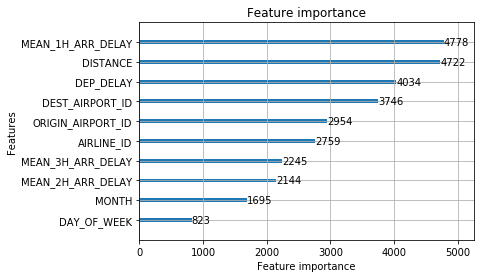

In [45]:
lgb.plot_importance(gbm)

In [34]:
gbm_CV_arr.best_params_

{'learning_rate': 0.05, 'max_depth': 20, 'num_leaves': 300}

/home/jct/Documents/Repos/envs/jupyter/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


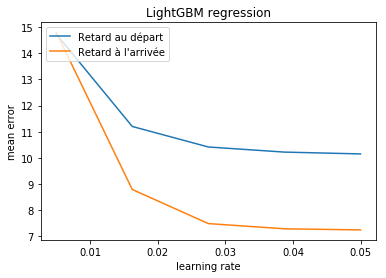

In [11]:
fix, ax = plt.subplots()
ax.plot([x['learning_rate'] for x in gbm_CV.cv_results_['params']], -gbm_CV.cv_results_['mean_train_score'], label='Retard au départ')
ax.plot([x['learning_rate'] for x in gbm_CV_arr.cv_results_['params']], -gbm_CV_arr.cv_results_['mean_train_score'], label='Retard à l\'arrivée')
plt.xlabel('learning rate')
plt.ylabel('mean error')
plt.title('LightGBM regression')
ax.legend(loc='upper left')

In [28]:
gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=300,
                        learning_rate=0.1, 
                        max_depth=50, 
                        num_leaves=900)
gbm.fit(X2_train, y2_train.ravel())
y_pred = gbm.predict(X2_test)
print(mean_absolute_error(y2_test, y_pred))

6.97217411632618


In [29]:
print(r2_score(y2_test, y_pred))

0.9335015044504614


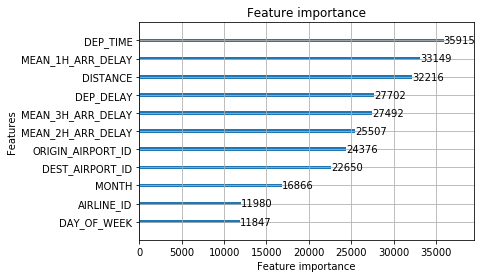

In [30]:
lgb.plot_importance(gbm)

## Influence de la taille de l'échantillon d'apprentissage

In [12]:
size_t = np.linspace(30, 90, 6)/100
ridge_dep = []
lasso_dep = []
lgbm_dep = []
ridge_arr = []
lasso_arr = []
lgbm_arr = []

In [14]:
for tt in size_t:
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1.values, test_size=tt)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2.values, test_size=tt)
    
    #ridge
    ridge = linear_model.Ridge(alpha=359381)
    ridge.fit(X1_train, y1_train)
    y_pred = ridge.predict(X1_test)
    ridge_dep.append(mean_absolute_error(y1_test, y_pred))
    
    ridge = linear_model.Ridge(alpha=2154)
    ridge.fit(X2_train, y2_train)
    y_pred = ridge.predict(X2_test)
    ridge_arr.append(mean_absolute_error(y2_test, y_pred))
    
    
    #lasso
    lasso = linear_model.Lasso(alpha=0.0774)
    lasso.fit(X1_train, y1_train)
    y_pred = lasso.predict(X1_test)oKhh
    lasso_dep.append(mean_absolute_error(y1_test, y_pred))
    
    lasso = linear_model.Lasso(alpha=0.0774)
    lasso.fit(X2_train, y2_train)
    y_pred = lasso.predict(X2_test)
    lasso_arr.append(mean_absolute_error(y2_test, y_pred))
    
    #gbm
    gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=300,
                        learning_rate=0.05, 
                        max_depth=20, 
                        num_leaves=200,
                        min_data_in_leaf=1000)
    gbm.fit(X1_train, y1_train.ravel())
    y_pred = gbm.predict(X1_test)
    lgbm_dep.append(mean_absolute_error(y1_test, y_pred))
    
    gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=300,
                        learning_rate=0.05, 
                        max_depth=20, 
                        num_leaves=200,
                        min_data_in_leaf=1000)
    gbm.fit(X2_train, y2_train.ravel())
    y_pred = gbm.predict(X2_test)
    lgbm_arr.append(mean_absolute_error(y2_test, y_pred))

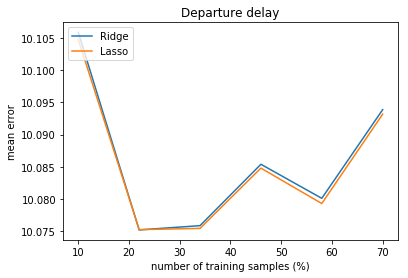

In [35]:
fix, ax = plt.subplots()
ax.plot(100-size_t*100, ridge_dep[6:], label='Ridge')
ax.plot(100-size_t*100, lasso_dep[6:], label='Lasso')
#ax.plot(100-size_t*100, lgbm_dep[6:], label='LGBM')
plt.xlabel('number of training samples (%)')
plt.ylabel('mean error')
plt.title('Departure delay')
ax.legend(loc='upper left')

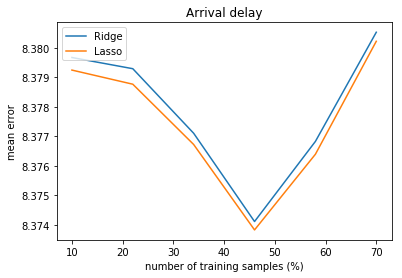

In [37]:
fix, ax = plt.subplots()
ax.plot(100-size_t*100, ridge_arr[6:], label='Ridge')
ax.plot(100-size_t*100, lasso_arr[6:], label='Lasso')
#ax.plot(100-size_t*100, lgbm_arr[6:], label='LGBM')
plt.xlabel('number of training samples (%)')
plt.ylabel('mean error')
plt.title('Arrival delay')
ax.legend(loc='upper left')

## Influence de la fonction d'erreur

In [49]:
gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=50)

gbm_params = { 'learning_rate': np.linspace(5.0, 50.0, 5)/1000, 'num_leaves': np.linspace(30, 300, 5).astype(int), 'max_depth': np.linspace(10, 40, 4).astype(int) }
gbm_CV = GridSearchCV(gbm, gbm_params, scoring = 'neg_mean_squared_error', cv = 5)

gbm_CV.fit(X2_train, y2_train.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([0.005  , 0.01625, 0.0275 , 0.03875, 0.05   ]), 'num_leaves': array([ 30,  97, 165, 232, 300]), 'max_depth': array([10, 20, 30, 40])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [50]:
gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=100,
                        learning_rate=gbm_CV.best_params_['learning_rate'], 
                        max_depth=gbm_CV.best_params_['max_depth'], 
                        num_leaves=gbm_CV.best_params_['num_leaves'])
gbm.fit(X2_train, y2_train.ravel())
y_pred = gbm.predict(X2_test)
print(mean_absolute_error(y2_test, y_pred))

7.067496254859693


In [51]:
gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=50)

gbm_params = { 'learning_rate': np.linspace(5.0, 50.0, 5)/1000, 'num_leaves': np.linspace(30, 300, 5).astype(int), 'max_depth': np.linspace(10, 40, 4).astype(int) }
gbm_CV = GridSearchCV(gbm, gbm_params, scoring = 'explained_variance', cv = 5)

gbm_CV.fit(X2_train, y2_train.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([0.005  , 0.01625, 0.0275 , 0.03875, 0.05   ]), 'num_leaves': array([ 30,  97, 165, 232, 300]), 'max_depth': array([10, 20, 30, 40])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='explained_variance', verbose=0)

In [52]:
gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=100,
                        learning_rate=gbm_CV.best_params_['learning_rate'], 
                        max_depth=gbm_CV.best_params_['max_depth'], 
                        num_leaves=gbm_CV.best_params_['num_leaves'])
gbm.fit(X2_train, y2_train.ravel())
y_pred = gbm.predict(X2_test)
print(mean_absolute_error(y2_test, y_pred))

7.067496254859693


In [53]:
gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=50)

gbm_params = { 'learning_rate': np.linspace(5.0, 50.0, 5)/1000, 'num_leaves': np.linspace(30, 300, 5).astype(int), 'max_depth': np.linspace(10, 40, 4).astype(int) }
gbm_CV = GridSearchCV(gbm, gbm_params, scoring = 'r2', cv = 5)

gbm_CV.fit(X2_train, y2_train.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([0.005  , 0.01625, 0.0275 , 0.03875, 0.05   ]), 'num_leaves': array([ 30,  97, 165, 232, 300]), 'max_depth': array([10, 20, 30, 40])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [54]:
gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=100,
                        learning_rate=gbm_CV.best_params_['learning_rate'], 
                        max_depth=gbm_CV.best_params_['max_depth'], 
                        num_leaves=gbm_CV.best_params_['num_leaves'])
gbm.fit(X2_train, y2_train.ravel())
y_pred = gbm.predict(X2_test)
print(mean_absolute_error(y2_test, y_pred))

7.067496254859693


# V. Export

## i. Référentiel

In [15]:
carriers = pd.DataFrame(df.loc[:, ['AIRLINE_ID', 'CARRIER']].drop_duplicates())
carriers = carriers.reset_index(drop=True)

In [16]:
airports = df.loc[:, ['ORIGIN', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME']]
airports.append(pd.DataFrame(df.loc[:, ['DEST', 'DEST_AIRPORT_ID', 'DEST_CITY_NAME']].values))
airports = airports.drop_duplicates(subset=['ORIGIN', 'ORIGIN_CITY_NAME'])
airports = airports.reset_index(drop=True)

In [ ]:
output = open('carriers.pkl', 'wb')
pickle.dump(carriers, output)
output.close()

output = open('airports.pkl', 'wb')
pickle.dump(airports, output)
output.close()

## ii. Encoders

In [ ]:
encoder = LabelEncoder()
encoder.fit(df2.loc[:,['AIRLINE_ID']].values.ravel())
output = open('carrier_encoder.pkl', 'wb')
pickle.dump(encoder, output)
output.close()

In [ ]:
encoder = LabelEncoder()
encoder.fit(df2.loc[:,['ORIGIN_AIRPORT_ID']].astype(float).values.ravel())
output = open('airport_encoder.pkl', 'wb')
pickle.dump(encoder, output)
output.close()

## iii. Modèles

In [38]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1.values, test_size=0.30)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2.values, test_size=0.30)

In [39]:
gbm_dep = lgb.LGBMRegressor(objective='regression',
                    n_estimators=300,
                    learning_rate=0.05, 
                    max_depth=20, 
                    num_leaves=200,
                    min_data_in_leaf=1000)
gbm_dep.fit(X1_train, y1_train.ravel())

gbm_arr = lgb.LGBMRegressor(objective='regression',
                    n_estimators=300,
                    learning_rate=0.05, 
                    max_depth=20, 
                    num_leaves=200,
                    min_data_in_leaf=1000)
gbm_arr.fit(X2_train, y2_train.ravel())

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=20,
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=1000,
       min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=200,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [42]:
#retained model for dep_delay is LightGBM regression
output = open('dep_delay_estimator.pkl', 'wb')
pickle.dump(gbm_dep, output)
output.close()

In [43]:
#retained model for arr_delay is LightGBM regression
output = open('arr_delay_estimator.pkl', 'wb')
pickle.dump(gbm_arr, output)
output.close()

In [20]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [44]:
df

QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE UNIQUE_CARRIER  \
0              1      1             6            3  2016-01-06             AA   
1              1      1             7            4  2016-01-07             AA   
2              1      1             8            5  2016-01-08             AA   
3              1      1             9            6  2016-01-09             AA   
4              1      1            10            7  2016-01-10             AA   
5              1      1            11            1  2016-01-11             AA   
6              1      1            12            2  2016-01-12             AA   
7              1      1            13            3  2016-01-13             AA   
8              1      1            14            4  2016-01-14             AA   
9              1      1            15            5  2016-01-15             AA   
10             1      1            16            6  2016-01-16             AA   
11             1      1            17            7  2016-01-17             AA   
12             1      1            18            1  2016-01-18             AA   
13             1      1            19            2  2016-01-19             AA   
14             1      1            20            3  2016-01-20             AA   
15             1      1            21            4  2016-01-21             AA   
16             1      1            22            5  2016-01-22             AA   
17             1      1            23            6  2016-01-23             AA   
18             1      1            24            7  2016-01-24             AA   
19             1      1            25            1  2016-01-25             AA   
20             1      1            26            2  2016-01-26             AA   
21             1      1            27            3  2016-01-27             AA   
22             1      1            28            4  2016-01-28             AA   
23             1      1            29            5  2016-01-29             AA   
24             1      1            30            6  2016-01-30             AA   
25             1      1            31            7  2016-01-31             AA   
26             1      1             1            5  2016-01-01             AA   
27             1      1             2            6  2016-01-02             AA   
28             1      1             3            7  2016-01-03             AA   
29             1      1             4            1  2016-01-04             AA   
...          ...    ...           ...          ...         ...            ...   
5556165        4     12            31            6  2016-12-31             WN   
5556166        4     12            31            6  2016-12-31             WN   
5556167        4     12            31            6  2016-12-31             WN   
5556168        4     12            31            6  2016-12-31             WN   
5556169        4     12            31            6  2016-12-31             WN   
5556170        4     12            31            6  2016-12-31             WN   
5556171        4     12            31            6  2016-12-31             WN   
5556172        4     12            31            6  2016-12-31             WN   
5556173        4     12            31            6  2016-12-31             WN   
5556174        4     12            31            6  2016-12-31             WN   
5556175        4     12            31            6  2016-12-31             WN   
5556176        4     12            31            6  2016-12-31             WN   
5556177        4     12            31            6  2016-12-31             WN   
5556178        4     12            31            6  2016-12-31             WN   
5556179        4     12            31            6  2016-12-31             WN   
5556180        4     12            31            6  2016-12-31             WN   
5556181        4     12            31            6  2016-12-31             WN   
5556182        4     12            31   

In [48]:
df.loc[4, ['CARRIER', 'FL_DATE', 'DEP_TIME', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'DEP_DELAY', 'ARR_DELAY']]

CARRIER                                AA
FL_DATE                        2016-01-10
DEP_TIME                             1240
ORIGIN_CITY_NAME    Dallas/Fort Worth, TX
DEST_CITY_NAME                Detroit, MI
DEP_DELAY                             100
ARR_DELAY                             113
Name: 4, dtype: object